In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as nplin
from mpl_toolkits.mplot3d import Axes3D
from scipy import optimize 

In [19]:
X = np.array(([3,5],[5,1],[10,2]), dtype = float)
y = np.array(([75],[82],[93]), dtype = float)

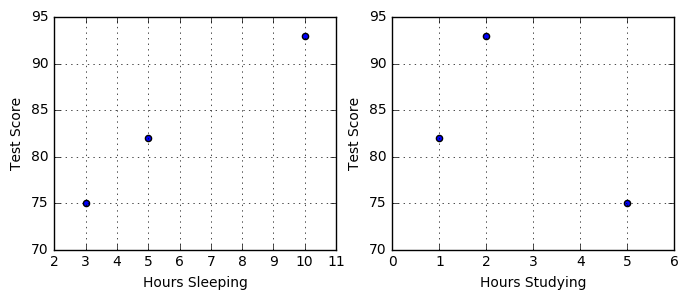

In [20]:
fig = plt.figure(0,(8,3))

plt.subplot(1,2,1)
plt.scatter(X[:,0], y)
plt.grid(1)
plt.xlabel('Hours Sleeping')
plt.ylabel('Test Score')

plt.subplot(1,2,2)
plt.scatter(X[:,1], y)
plt.grid(1)
plt.xlabel('Hours Studying')
plt.ylabel('Test Score')
plt.show()

In [21]:
X = X/np.amax(X, axis=0)
y = y/100

In [22]:
trainX = np.array(([3,5], [5,1], [10,2], [6,1.5]), dtype=float)
trainY = np.array(([75], [82], [93], [70]), dtype=float)

testX = np.array(([4, 5.5], [4.5,1], [9,2.5], [6, 2]), dtype=float)
testY = np.array(([70], [89], [85], [75]), dtype=float)

trainX = trainX/np.amax(trainX, axis=0)
trainY = trainY/100

testX = testX/np.amax(trainX, axis=0)
testY = testY/100

In [23]:
class NeuralNetwork(object):
    def __init__(self, Lambda=0):
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3
        
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        
        self.Lambda = Lambda
        
    def forward(self, X):
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)/X.shape[0] + (self.Lambda/2)*(np.sum(self.W1**2)+np.sum(self.W2**2))
        return J
        
    def costFunctionPrime(self, X, y):
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)/X.shape[0] + self.Lambda*self.W2
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)/X.shape[0] + self.Lambda*self.W1
        
        return dJdW1, dJdW2
    
    def getParams(self):
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        W1_start = 0
        W1_end = self.hiddenLayerSize*self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], \
                             (self.inputLayerSize, self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], \
                             (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

In [24]:
NN = NeuralNetwork(Lambda=0.0001)

In [25]:
def computeNumericalGradient(N, X, y):
        paramsInitial = N.getParams()
        numgrad = np.zeros(paramsInitial.shape)
        perturb = np.zeros(paramsInitial.shape)
        e = 1e-4

        for p in range(len(paramsInitial)):
            #Set perturbation vector
            perturb[p] = e
            N.setParams(paramsInitial + perturb)
            loss2 = N.costFunction(X, y)
            
            N.setParams(paramsInitial - perturb)
            loss1 = N.costFunction(X, y)

            #Compute Numerical Gradient
            numgrad[p] = (loss2 - loss1) / (2*e)

            #Return the value we changed to zero:
            perturb[p] = 0
            
        #Return Params to original value:
        N.setParams(paramsInitial)

        return numgrad

In [26]:
numgrad = computeNumericalGradient(NN, X, y)
grad = NN.computeGradients(X,y)
nplin.norm(grad-numgrad)/nplin.norm(grad+numgrad)

7.9959608247492317e-11

In [27]:
class trainer(object):
    def __init__(self, N):
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))
        self.testJ.append(self.N.costFunction(self.testX, self.testY))
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        
        return cost, grad
        
    def train(self, trainX, trainY, testX, testY):
        self.X = trainX
        self.y = trainY
        
        self.testX = testX
        self.testY = testY

        self.J = []
        self.testJ = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(trainX, trainY), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res

In [28]:
T = trainer(NN)
T.train(trainX, trainY, testX, testY)

Optimization terminated successfully.
         Current function value: 0.002618
         Iterations: 132
         Function evaluations: 136
         Gradient evaluations: 136


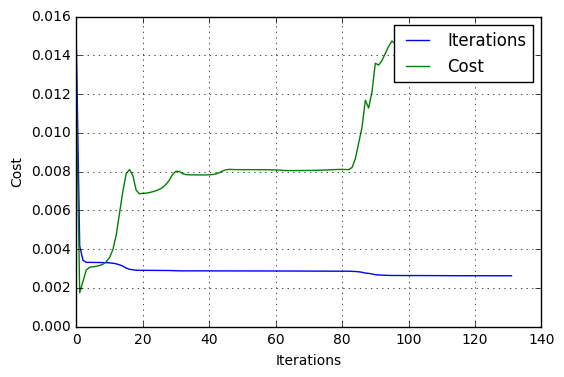

In [29]:
plt.plot(T.J)
plt.plot(T.testJ)
plt.grid(1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend(['Iterations', 'Cost'])
plt.show()

In [30]:
cost1 = NN.costFunction(X,y)
dJdW1, dJdW2 = NN.costFunctionPrime(X,y)

scalar = 3
NN.W1 = NN.W1 + scalar*dJdW1
NN.W2 = NN.W2 + scalar*dJdW2
cost2 = NN.costFunction(X,y)

dJdW1, dJdW2 = NN.costFunctionPrime(X,y)
NN.W1 = NN.W1 - scalar*dJdW1
NN.W2 = NN.W2 - scalar*dJdW2
cost3 = NN.costFunction(X, y)

print cost1, cost2, cost3

[ 0.0016446] [ 0.00174889] [ 0.00163449]


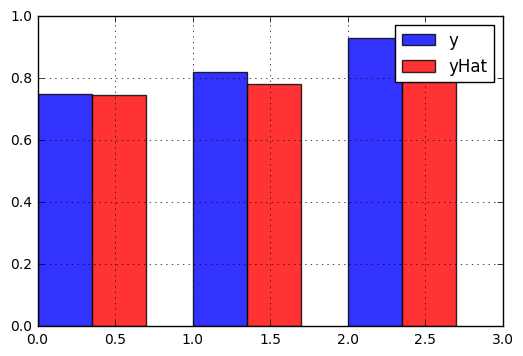

In [31]:
plt.bar([0,1,2], y, width = 0.35, alpha=0.8, color='b')
plt.bar([0.35,1.35,2.35],NN.yHat, width = 0.35, color='r', alpha=0.8)
plt.grid(1)
plt.legend(['y', 'yHat'])
plt.show()

In [32]:
hoursSleep = np.linspace(0, 10, 100)
hoursStudy = np.linspace(0, 5, 100)

hoursSleepNorm = hoursSleep/10.
hoursStudyNorm = hoursStudy/5.

a, b  = np.meshgrid(hoursSleepNorm, hoursStudyNorm)

allInputs = np.zeros((a.size, 2))
allInputs[:, 0] = a.ravel()
allInputs[:, 1] = b.ravel()


allOutputs = NN.forward(allInputs)

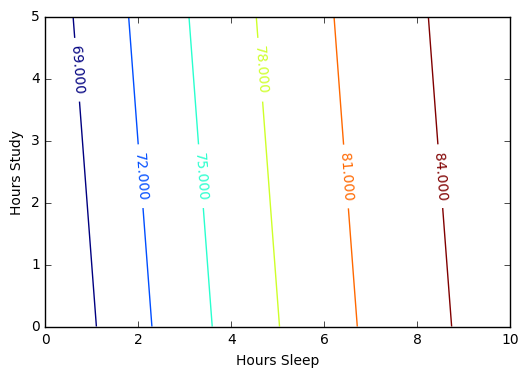

In [33]:
yy = np.dot(hoursStudy.reshape(100,1), np.ones((1,100)))
xx = np.dot(hoursSleep.reshape(100,1), np.ones((1,100))).T

CS = plt.contour(xx,yy,100*allOutputs.reshape(100, 100))
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel('Hours Sleep')
plt.ylabel('Hours Study')
plt.show()

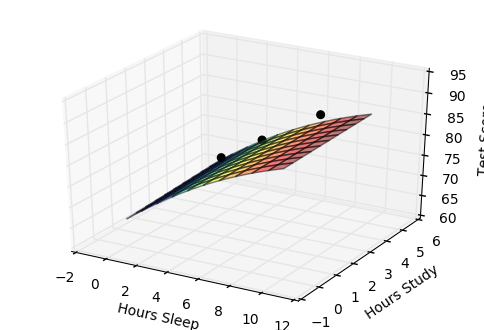

In [34]:
#%matplotlib qt

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

#ax.scatter(10*X[:,0], 5*X[:,1], 100*y, c='k', alpha = 1, s=30)

ax.scatter(10*X[:,0], 5*X[:,1], 100*y, c='k', alpha = 1, s=30)

surf = ax.plot_surface(xx, yy, 100*allOutputs.reshape(100, 100),cmap=plt.cm.jet, alpha = 0.5)

ax.set_xlabel('Hours Sleep')
ax.set_ylabel('Hours Study')
ax.set_zlabel('Test Score')
plt.show()